# Mushroom Edibility Classification Using Feature-Based Machine Learning Approach

by Benjamin Frizzell, Hankun Xiao, Essie Zhang, Mason Zhang 2024/11/23

Note: before we set up the conda lock, please use the following command to load the dataset

`Install the ucimlrepo package`

#### Import Library

In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import pandera as pa
from pandera import Check
from deepchecks import Dataset
import json
import logging
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Summary

In this project, a Support Vector Classifier was built and tuned to identify mushrooms edibility. A mushroom is classified as edible or poisonous with given color, habitat, class, and others. The final classifier performed quite well on unseen test data, with a final overall accuracy of 0.99 and $F_{\beta}$ score with $\beta = 2$ of 0.99. Furthermore, we use confusion matrix to show the accuracy of classification poisonous or edible mushroom. The model makes 12174 correct predictions out of 12214 test observations. 17 mistakes were predicting a poisonous mushroom as edible (false negative), while 23 mistakes were predicting a edible mushroom as poisonous (false positive). The model’s performance shows promise for implementation, prioritizing safety by minimizing false negatives that could result in consuming poisonous mushrooms. While false positives may lead to unnecessarily discarding safe mushrooms, they pose no safety risk. Further development is needed to make this model useful. Research should focus on improving performance and analyzing cases of incorrect predictions.

## Introduction

Mushrooms are the most common food which is rich in vitamins and minerals. However, not all mushrooms can be consumed directly, most of them are poisonous and identifying edible or poisonous mushroom through the naked eye is quite difficult. Our aim is to using machine learning to identify mushrooms edibility. In this project, three methods are used to detect the edibility of mushrooms: Support Vector Classifier (SVC), K-Nearest Neighbors (KNN), and Logistic Regression. 

## Methods

### Data

The dataset used in this project is the Secondary Mushroom Dataset created by Wagner, D., Heider, D., & Hattab, G. from UCI Machine Learning Repository. This dataset contains 61069 hypothetical mushrooms with caps based on 173 species (353 mushrooms per species). Each mushroom is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended (the latter class was combined with the poisonous class).

### Analysis

The mushroom dataset is balanced with 56% of poisonous mushroom and 44% of edible mushroom. All variables were standardized and variables with more than 15% missing values are dropped, because imputing a variable that has a significant proportion of missing data might introduce too much noise or bias, making it unreliable. Data was splitted with 80% being partitioned into the training set and 20% being partitioned into the test set. Three classification models including Support Vector Classifier (SVC), K-Nearest Neighbors (KNN), and Logistic Regression are used to predict whether a mushroom is edible or poisonous. The fine tuned Support Vector Classifier has the best overall performance. The hyperparameter was chosen using 5-fold cross validation with $F_{\beta}$ score as the classification metric. $\beta$ was chosen to be set to 2 for the $F_{\beta}$ score to increase the weight on recall during fitting because predicting a mushroom to be edible when it is in fact poisonous could have severe health consequences. Therefore the goal is to prioritize the minimization of false negatives. The Python programming language (Van Rossum and Drake 2009) and the following Python packages were used to perform the analysis: Matplotlib (Hunter, 2007), Pandas (McKinney, 2010), Scikit-learn (Pedregosa et al., 2011), NumPy (Harris et al., 2020), SciPy (Virtanen et al., 2020), UCIMLRepo.

## Results & Discussion

The EDA shows that all numeric columns in the mushroom dataset are nearly normal with some skewness. A robust preprocessing scheme `QuantileTransformer` is used because it can transform skewed data or heavy-tailed distributions into a more Gaussian-like shape and reduce the impact of outliers.
`OneHotEncoder` is applied for categorical features in the mushroom dataset, because each feature does not contains much categories and they are not ordered. It is critical to keep all important information in the features. Since ring type feature has many missing values, it was filled in with a "Missing" class. Treating missing values as a distinct category provides a way to model the absence of data directly. This can be valuable because missingness itself might carry information.

#### Load Data

In [2]:
# fetch dataset as pandas DataFrames
secondary_mushroom = fetch_ucirepo(id=848) 
X = secondary_mushroom.data.features 
y = secondary_mushroom.data.targets 

##### Before splitting the data into test and training sets, we want to check for missing values in each column to determine whether they can be used in our model.

In [3]:
# Check the missing values
missing_values = X.isnull().sum().reset_index()
missing_values.columns = ['Column', 'Missing Count']

# Highlight values with a gradient
styled_missing = missing_values.style.format(
    precision=0
).background_gradient(
    subset=['Missing Count'],
    cmap='YlOrRd'
).set_caption("Missing Values by Column")

# Display the styled DataFrame
display(styled_missing)

,Column,Missing Count
0,cap-diameter,0
1,cap-shape,0
2,cap-surface,14120
3,cap-color,0
4,does-bruise-or-bleed,0
5,gill-attachment,9884
6,gill-spacing,25063
7,gill-color,0
8,stem-height,0
9,stem-width,0


In [4]:
colunms_to_drop = ['cap-surface', 'gill-attachment', 'gill-spacing', 
                   'stem-root', 'stem-surface', 'veil-type', 'veil-color', 
                   'spore-print-color']
X = X.drop(columns = colunms_to_drop)

After examining the data set, we decided to drop columns with a high proportion of missing values (over 15%), which include `cap-surface`, `gill-attachment`, `gill-spacing`, `stem-root`, `stem-surface`, `veil-type`, `veil-color`, and `spore-print-color`.

#### Data Validation

In [5]:
# combine features and target to the same dataframe named mushroom
mushroom = X.copy()
mushroom['target'] = y

schema = pa.DataFrameSchema(
    
    {
        "target": pa.Column(str, pa.Check.isin(['e', 'p'])),
        # check missing value proportion (threshold=15%) AND value ranges for all features
        "cap-diameter": pa.Column(float, checks = [pa.Check(lambda s: s.isna().mean() <= 0.15, 
                                                  element_wise=False, 
                                                  error="Too many null values in 'cap-diameter' column."), 
                                                   pa.Check.between(0, 100)],
                                  nullable=True), 
        "cap-shape": pa.Column(str, checks = [pa.Check(lambda s: s.isna().mean() <= 0.15, 
                                                  element_wise=False, 
                                                  error="Too many null values in 'cap-shape' column."), 
                                              pa.Check.isin(['x', 'f', 'p', 'b', 'c', 's', 'o'])],
                                  nullable=True),     
        "cap-color": pa.Column(str, checks = [pa.Check(lambda s: s.isna().mean() <= 0.15, 
                                                  element_wise=False, 
                                                  error="Too many null values in 'cap-color' column."), 
                                              pa.Check.isin(['o', 'e', 'n', 'g', 'r', 'w', 'y', 'p', 'u', 'b', 'l', 'k'])],
                               nullable=True),
        "does-bruise-or-bleed": pa.Column(str, checks = [pa.Check(lambda s: s.isna().mean() <= 0.15, 
                                                                  element_wise=False, 
                                                                  error="Too many null values in 'does-bruise-or-bleed' column."), 
                                                         pa.Check.isin(['f', 't'])],
                                          nullable=True),
        "gill-color": pa.Column(str, checks = [pa.Check(lambda s: s.isna().mean() <= 0.15, 
                                                  element_wise=False, 
                                                  error="Too many null values in 'gill-color' column."), 
                                               pa.Check.isin(['w', 'n', 'p', 'u', 'b', 'g', 'y', 'r', 'e', 'o', 'k', 'l', 'f'])],
                                  nullable=True),
        "stem-height": pa.Column(float, checks = [pa.Check(lambda s: s.isna().mean() <= 0.15, 
                                                  element_wise=False, 
                                                  error="Too many null values in 'stem-height' column."), 
                                                   pa.Check.between(0, 100)],
                                  nullable=True),
        "stem-width": pa.Column(float, checks = [pa.Check(lambda s: s.isna().mean() <= 0.15, 
                                                  element_wise=False, 
                                                  error="Too many null values in 'stem-width' column."), 
                                                 pa.Check.between(0, 150)],
                                nullable=True),
        "stem-color": pa.Column(str, checks = [pa.Check(lambda s: s.isna().mean() <= 0.15, 
                                                  element_wise=False, 
                                                  error="Too many null values in 'stem-color' column."), 
                                               pa.Check.isin(['o', 'e', 'n', 'g', 'r', 'w', 'y', 'p', 'u', 'b', 'l', 'k', 'f'])],
                                  nullable=True),
        "has-ring": pa.Column(str, checks = [pa.Check(lambda s: s.isna().mean() <= 0.15, 
                                                  element_wise=False, 
                                                  error="Too many null values in 'has-ring' column."), 
                                             pa.Check.isin(['t', 'f'])],
                                  nullable=True),
        "ring-type": pa.Column(str, checks = [pa.Check(lambda s: s.isna().mean() <= 0.15, 
                                                  element_wise=False, 
                                                  error="Too many null values in 'ring-type' column."), 
                                              pa.Check.isin(['c', 'e', 'r', 'g', 'l', 'p', 's', 'z', 'y', 'm', 'f'])],
                                  nullable=True),
        "habitat": pa.Column(str, checks = [pa.Check(lambda s: s.isna().mean() <= 0.15, 
                                                  element_wise=False, 
                                                  error="Too many null values in 'habitat' column."), 
                                            pa.Check.isin(['g', 'l', 'm', 'p', 'h', 'u', 'w', 'd'])],
                                  nullable=True),
        "season": pa.Column(str, checks = [pa.Check(lambda s: s.isna().mean() <= 0.15, 
                                                  element_wise=False, 
                                                  error="Too many null values in 'season' column."),
                                           pa.Check.isin(['s', 'u', 'a', 'w'])],
                                  nullable=True)
        
    },
    checks=[
        pa.Check(lambda df: ~mushroom.duplicated().any(), error="Duplicate rows found."),
        pa.Check(lambda df: ~(mushroom.isna().all(axis=1)).any(), error="Empty rows found.")
    ],
    drop_invalid_rows=True
)

schema.validate(mushroom, lazy=True).drop_duplicates().dropna(how="all")

,cap-diameter,cap-shape,cap-color,does-bruise-or-bleed,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season,target
0,15.26,x,o,f,w,16.95,17.09,w,t,g,d,w,p
1,16.60,x,o,f,w,17.99,18.19,w,t,g,d,u,p
2,14.07,x,o,f,w,17.80,17.74,w,t,g,d,w,p
3,14.17,f,e,f,w,15.77,15.98,w,t,p,d,w,p
4,14.64,x,o,f,w,16.53,17.20,w,t,p,d,w,p
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61064,1.18,s,y,f,f,3.93,6.22,y,f,f,d,a,p
61065,1.27,f,y,f,f,3.18,5.43,y,f,f,d,a,p
61066,1.27,s,y,f,f,3.86,6.37,y,f,f,d,u,p
61067,1.24,f,y,f,f,3.56,5.44,y,f,f,d,u,p


##### create validation_error.log file

In [6]:
# create validation_error.log file

# Configure logging
logging.basicConfig(
    filename="validation_errors.log",
    filemode="w",
    format="%(asctime)s - %(message)s",
    level=logging.INFO,
)

# Define the schema
schema = pa.DataFrameSchema(
    
    {
        "target": pa.Column(str, pa.Check.isin(['e', 'p'])),
        
        "cap-diameter": pa.Column(float, checks = [pa.Check(lambda s: s.isna().mean() <= 0.15, 
                                                  element_wise=False, 
                                                  error="Too many null values in 'cap-diameter' column."), 
                                                   pa.Check.between(0, 100)],
                                  nullable=True),
        "cap-shape": pa.Column(str, checks = [pa.Check(lambda s: s.isna().mean() <= 0.15, 
                                                  element_wise=False, 
                                                  error="Too many null values in 'cap-shape' column."), 
                                              pa.Check.isin(['x', 'f', 'p', 'b', 'c', 's', 'o'])],
                                  nullable=True),     
        "cap-color": pa.Column(str, checks = [pa.Check(lambda s: s.isna().mean() <= 0.15, 
                                                  element_wise=False, 
                                                  error="Too many null values in 'cap-color' column."), 
                                              pa.Check.isin(['o', 'e', 'n', 'g', 'r', 'w', 'y', 'p', 'u', 'b', 'l', 'k'])],
                               nullable=True),
        "does-bruise-or-bleed": pa.Column(str, checks = [pa.Check(lambda s: s.isna().mean() <= 0.15, 
                                                                  element_wise=False, 
                                                                  error="Too many null values in 'does-bruise-or-bleed' column."), 
                                                         pa.Check.isin(['f', 't'])],
                                          nullable=True),
        "gill-color": pa.Column(str, checks = [pa.Check(lambda s: s.isna().mean() <= 0.15, 
                                                  element_wise=False, 
                                                  error="Too many null values in 'gill-color' column."), 
                                               pa.Check.isin(['w', 'n', 'p', 'u', 'b', 'g', 'y', 'r', 'e', 'o', 'k', 'l', 'f'])],
                                  nullable=True),
        "stem-height": pa.Column(float, checks = [pa.Check(lambda s: s.isna().mean() <= 0.15, 
                                                  element_wise=False, 
                                                  error="Too many null values in 'stem-height' column."), 
                                                   pa.Check.between(0, 100)],
                                  nullable=True),
        "stem-width": pa.Column(float, checks = [pa.Check(lambda s: s.isna().mean() <= 0.15, 
                                                  element_wise=False, 
                                                  error="Too many null values in 'stem-width' column."), 
                                                 pa.Check.between(0, 150)],
                                nullable=True),
        "stem-color": pa.Column(str, checks = [pa.Check(lambda s: s.isna().mean() <= 0.15, 
                                                  element_wise=False, 
                                                  error="Too many null values in 'stem-color' column."), 
                                               pa.Check.isin(['o', 'e', 'n', 'g', 'r', 'w', 'y', 'p', 'u', 'b', 'l', 'k', 'f'])],
                                  nullable=True),
        "has-ring": pa.Column(str, checks = [pa.Check(lambda s: s.isna().mean() <= 0.15, 
                                                  element_wise=False, 
                                                  error="Too many null values in 'has-ring' column."), 
                                             pa.Check.isin(['t', 'f'])],
                                  nullable=True),
        "ring-type": pa.Column(str, checks = [pa.Check(lambda s: s.isna().mean() <= 0.15, 
                                                  element_wise=False, 
                                                  error="Too many null values in 'ring-type' column."), 
                                              pa.Check.isin(['c', 'e', 'r', 'g', 'l', 'p', 's', 'z', 'y', 'm', 'f'])],
                                  nullable=True),
        "habitat": pa.Column(str, checks = [pa.Check(lambda s: s.isna().mean() <= 0.15, 
                                                  element_wise=False, 
                                                  error="Too many null values in 'habitat' column."), 
                                            pa.Check.isin(['g', 'l', 'm', 'p', 'h', 'u', 'w', 'd'])],
                                  nullable=True),
        "season": pa.Column(str, checks = [pa.Check(lambda s: s.isna().mean() <= 0.15, 
                                                  element_wise=False, 
                                                  error="Too many null values in 'season' column."),
                                           pa.Check.isin(['s', 'u', 'a', 'w'])],
                                  nullable=True)
        
    },
    checks=[
        pa.Check(lambda df: ~mushroom.duplicated().any(), error="Duplicate rows found."),
        pa.Check(lambda df: ~(mushroom.isna().all(axis=1)).any(), error="Empty rows found.")
    ],
    drop_invalid_rows = False
)

# Initialize error cases DataFrame
error_cases = pd.DataFrame()
data = mushroom.copy()

# Validate data and handle errors
try:
    validated_data = schema.validate(data, lazy=True)
except pa.errors.SchemaErrors as e:
    error_cases = e.failure_cases

    # Convert the error message to a JSON string
    error_message = json.dumps(e.message, indent=2)
    logging.error("\n" + error_message)

# Filter out invalid rows based on the error cases
if not error_cases.empty:
    invalid_indices = error_cases["index"].dropna().unique()
    validated_data = (
        data.drop(index=invalid_indices)
        .reset_index(drop=True)
        .drop_duplicates()
        .dropna(how="all")
    )
else:
    validated_data = data

In [7]:
validated_data.shape

(60903, 13)

In [8]:
X = validated_data.drop(['target'], axis=1)
y = validated_data['target']

In [9]:
# Split the data test and training set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)

In [10]:
mushroom_train = X_train.copy()
mushroom_train['target'] = y_train

In [11]:
# check anomalous correlations
numeric_columns = mushroom_train.select_dtypes(include='number')
corr_matrix = numeric_columns.corr()
corr_matrix

,cap-diameter,stem-height,stem-width
cap-diameter,1.000000,0.420087,0.692574
stem-height,0.420087,1.000000,0.431192
stem-width,0.692574,0.431192,1.000000


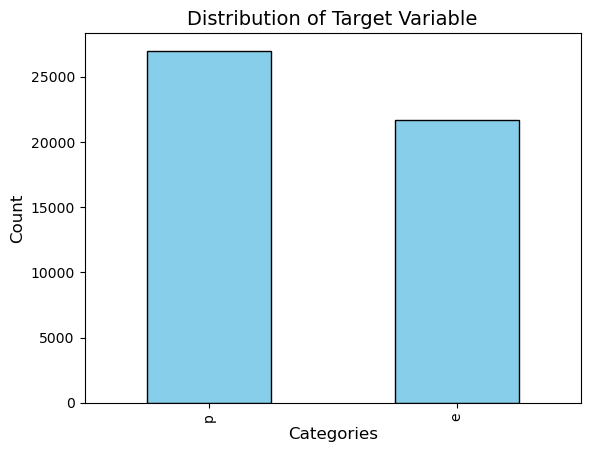

In [12]:
# check the distribution of target variable
category_counts = y_train.value_counts()

# Plotting the bar chart
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Adding labels and title
plt.title('Distribution of Target Variable', fontsize=14)
plt.xlabel('Categories', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Show the plot
plt.show()

#### EDA

##### Part 1: Missing Values

In [13]:
# Check the missing values
missing_values = X.isnull().sum().reset_index()
missing_values.columns = ['Column', 'Missing Count']

# Highlight values with a gradient
styled_missing = missing_values.style.format(
    precision=0
).background_gradient(
    subset=['Missing Count'],
    cmap='YlOrRd'
).set_caption("Missing Values by Column")

# Display the styled DataFrame
display(styled_missing)

,Column,Missing Count
0,cap-diameter,0
1,cap-shape,0
2,cap-color,0
3,does-bruise-or-bleed,0
4,gill-color,0
5,stem-height,0
6,stem-width,0
7,stem-color,0
8,has-ring,0
9,ring-type,2471


The initial `X_train` assessment has demonstrated no missing values within remaining features except for the `ring-type` . However, the proportion of missing values in this feature is reasonable, and simply dropping this column could result in loss of potentially valuable information, introduction of biases etc., which might reduce the overall accuracy of the classifier. Therefore, we decided to retain this column and perform imputation on `ring-type` in the data preprocessing phase. 

##### Part 2: The distribution of numeric features

To understand the numeric features in the data set, we plotted histograms for each numeric column in `X_train`, which helps identify the distribution patterns as well as detecting any skewness or outliers. The numeric columns being plotted are `cap-diameter`, `stem-height`, and `stem-width`.

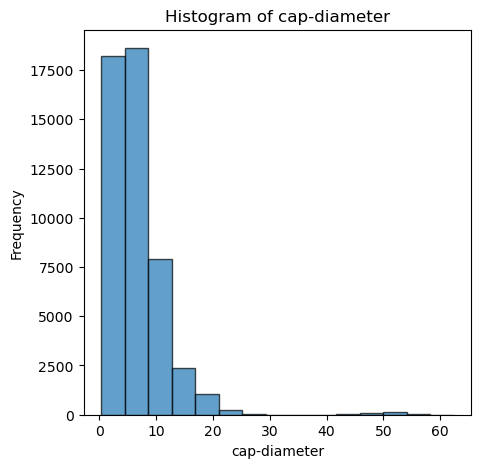

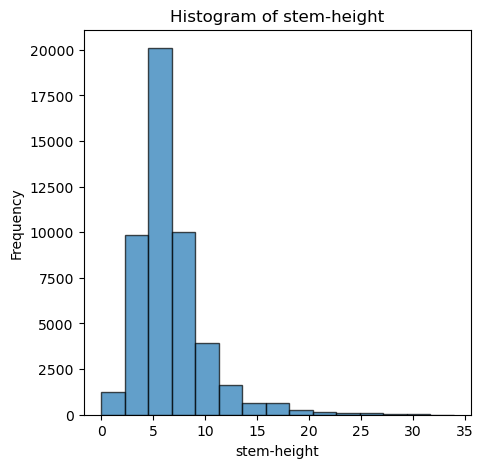

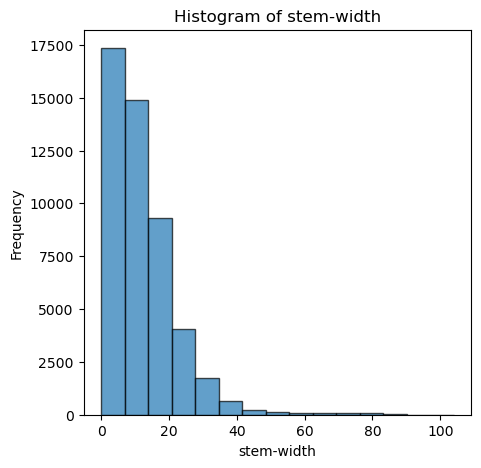

In [14]:
numeric_columns = X_train.select_dtypes(include='number')  # Select only numeric columns

for column in numeric_columns.columns:
    plt.figure(figsize=(5,5))
    plt.hist(X_train[column], bins=15, edgecolor='black', alpha=0.7)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

Based on the histograms, here are our findings for each feature being plotted.

1. `cap-diameter`: The distribution is highly skewed to the right, with most values concentrated between 0 and 10 cm. There are also some outliers sitting at around 40 to 60 cm.  

2. `stem-height`: Slightly right-skewed distribution. The majority of mushrooms have stem heights between 4 and 10 cm, with few having stem heights over 20 cm.

3. `stem-width`: Another heavily right-skewed distribution, with the majority of mushrooms having stem width below 20 cm, and a some rare cases exceeding 50 cm.

The skewness observed across the 3 numeric features will be addressed in the preprocessing phase with `QuantileTransformer` from `sklearn.preprocessing` which maps data to a normal distribution while retaining the relative rank of values, making them more suitable for models sensitive to feature distributions, such as `SVC` and `LogisticRegression`. 

##### Part 3: The distribution of categorical features

To understand the categorical features in the data set, we analyzed their frequency and percentage distributions, providing insights into the variability and class imbalance that might occur for each feature. 

In [15]:
categorical_columns = X_train.select_dtypes(include='object')  # Select only categorical columns

# Calculate frequency and percentage for each categorical features
for column in categorical_columns.columns:
    print(f"Frequency and Percentage for '{column}':")
    
    # Frequency
    frequency = X_train[column].value_counts()
    # Percentage
    percentage = round(X_train[column].value_counts(normalize=True) * 100, 2)
    
    # Combine into one DataFrame
    freq_percent_df = pd.DataFrame({
        "Frequency": frequency,
        "Percentage": percentage
    })

    # Highlight values with a gradient
    styled_df = freq_percent_df.style.format(
        precision=2
    ).background_gradient(
        subset=['Percentage'],
        cmap='YlOrRd'
    )

    # Display the styled DataFrame
    display(styled_df)
    print("-" * 40, '\n')

Frequency and Percentage for 'cap-shape':


,Frequency,Percentage
cap-shape,,
x,21510,44.15
f,10698,21.96
s,5717,11.73
b,4615,9.47
o,2634,5.41
p,2098,4.31
c,1450,2.98


---------------------------------------- 

Frequency and Percentage for 'cap-color':


,Frequency,Percentage
cap-color,,
n,19407,39.83
y,6876,14.11
w,6175,12.67
g,3410,7.00
e,3205,6.58
o,2905,5.96
r,1399,2.87
u,1355,2.78
p,1332,2.73


---------------------------------------- 

Frequency and Percentage for 'does-bruise-or-bleed':


,Frequency,Percentage
does-bruise-or-bleed,,
f,40333,82.78
t,8389,17.22


---------------------------------------- 

Frequency and Percentage for 'gill-color':


,Frequency,Percentage
gill-color,,
w,14836,30.45
n,7742,15.89
y,7595,15.59
p,4769,9.79
g,3295,6.76
f,2734,5.61
o,2312,4.75
k,1908,3.92
r,1131,2.32


---------------------------------------- 

Frequency and Percentage for 'stem-color':


,Frequency,Percentage
stem-color,,
w,18377,37.72
n,14478,29.72
y,6291,12.91
g,2090,4.29
o,1733,3.56
e,1628,3.34
u,1189,2.44
p,814,1.67
f,705,1.45


---------------------------------------- 

Frequency and Percentage for 'has-ring':


,Frequency,Percentage
has-ring,,
f,36495,74.90
t,12227,25.10


---------------------------------------- 

Frequency and Percentage for 'ring-type':


,Frequency,Percentage
ring-type,,
f,38440,82.28
e,1964,4.20
z,1713,3.67
l,1151,2.46
r,1129,2.42
p,1028,2.20
g,1005,2.15
m,287,0.61


---------------------------------------- 

Frequency and Percentage for 'habitat':


,Frequency,Percentage
habitat,,
d,35162,72.17
g,6403,13.14
l,2539,5.21
m,2344,4.81
h,1598,3.28
p,298,0.61
w,288,0.59
u,90,0.18


---------------------------------------- 

Frequency and Percentage for 'season':


,Frequency,Percentage
season,,
a,24079,49.42
u,18300,37.56
w,4149,8.52
s,2194,4.50


---------------------------------------- 



Based on the Frequency and Percentage distributions, here are our findings:

1. `cap-shape`: The most common cap shape is `x` (convex), comprising 43.97% of the data. Other shapes like `f` (flat) and `s` (sunken) are also prevalent, while `c` (conical) is the least common with 2.95% appearance.

2. `cap-color`: The most frequently appeared color is `n` (brown), with 39.71% of the data. Other colors like `y` (yellow), `w` (white), and `g` (gray) are also well-represented, while rare colors like `b` (buff) and `l` (blue) appear in less than 2% of the data.

3. `does-bruise-or-bleed`: The majority of the mushrooms are `f` (do not bruise or bleed), while their counterpart make up 17.26% of the data.

4. `gill-color`: The most common gill color is `w` (white), with 30.45% of the data. Other colors such as `n` (brown) and `y` (yellow) are also frequent, while rare gill colors like `e` (red), `b` (buff) and `u` (purple) appear in less than 2% of the data.

5. `stem-color`: `w` (white) and `n` (brown) are the dominating stem colors, accounting for 37.75% and 29.5% of the data, respectively. Other colors like `r` (green), `l` (blue) and `b` (buff) are less frequent, appearing in less than 1% of the observations.

6. `has-ring`: Most mushrooms are `f` (do not have a ring), with 74.84% observations. The remaining 25.16% mushrooms are `t` (have a ring).

7. `ring-type`: `f` (none) is the most common ring type, accounting for 82.3% of the data. Other types like `e` (evanescent) and `z` (zone) are less frequent, while rare types like `m` (movable) occur in less than 1% of the data.

8. `habitat`: The predominant habitat is `d` (woods), with 72.46% appearance. Other habitats such as `g` (grasses) and `l` (leaves) are less common, while `w` (waste), `p` (paths), and `u` (urban) only make up less than 1% of the data individually.

9. `season`: Most mushrooms grow in `a` (autumn), comprising 49.36% of the data, followed by `u` (summer) at 37.5%. The other two seasons `w` (winter) and `s` (spring) are less frequent.

Categorical features will be encoded into binary format in the following preprocessing phase with `OneHotEncoder`. Since we are dealing with a mix of binary and non-binary categorical features, for features like `does-bruise-or-bleed` and `has-ring` that have two unique values, they will be handled with `drop='if_binary'` argument to reduce redundancy while still capturing the information. 

##### Part 4: The distribution of the target

The target variable `class` represents whether a mushroom is `p` (poisonous) or `e` (edible). Understanding the distribution of the target helps assessing class balance, which might have impact on models' performance.

In [16]:
 # Frequency
frequency = y_train.value_counts()
# Percentage
percentage = round(y_train.value_counts(normalize=True) * 100, 2)

# Combine into one DataFrame
freq_percent_df = pd.DataFrame({
    "Frequency": frequency,
    "Percentage": percentage
})
freq_percent_df

,Frequency,Percentage
target,,
p,26996,55.41
e,21726,44.59


Based on the Frequency and Percentage distribution, here are our findings:

1. `p` (Poisonous): There are 27,143 instances of poisonous mushrooms, accounting for 55.56% of the data.

2. `e` (Edible): There are 21,712 instances of edible mushrooms, constituting 44.44% of the data.

Using $F_{\beta}$, precision, recall, or confusion matrix to evaluate the model's performance is advisable in the following procedure. 

#### Preprocessing and Model Building

Three classification models including Support Vector Classifier (SVC), K-Nearest Neighbors (KNN), and Logistic Regression are used to predict whether a mushroom is edible or poisonous. Predicting a mushroom to be edible when it is in fact poisonous could have severe health consequences. Therefore the best model should prioritize the minimization of this error. To do this, we can evaluate models on an $F_{\beta}$ score with $\beta = 2$.

In [17]:
# loading in some models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [18]:
# importing required preprocessors, pipelines, etc.
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import QuantileTransformer,OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# converting targets to Series objects to avoid warnings
y_train = y_train.squeeze()
y_test = y_test.squeeze()

# random state for reproducability
SEED = 123

# feature sets for each transformation
numeric_cols = ['cap-diameter','stem-height','stem-width']
categorical_cols = ['does-bruise-or-bleed','has-ring','cap-shape','cap-color','gill-color','stem-color','habitat','season']
impute_cols = ['ring-type']

# creating transformers
numeric_transformer = QuantileTransformer(output_distribution='normal',random_state=SEED)
categorical_transformer = OneHotEncoder(drop='if_binary',handle_unknown='ignore',sparse_output=False)
impute_transformer = make_pipeline(
    SimpleImputer(strategy='constant',fill_value = 'missing'),
    categorical_transformer
)

# final preprocessor
preprocessor = make_column_transformer(
    (numeric_transformer,numeric_cols),
    (impute_transformer,impute_cols),
    (categorical_transformer,categorical_cols)
)
preprocessor

ColumnTransformer(transformers=[('quantiletransformer',
                                 QuantileTransformer(output_distribution='normal',
                                                     random_state=123),
                                 ['cap-diameter', 'stem-height', 'stem-width']),
                                ('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['ring-type']),
                                ('onehotencoder',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['does-bruise-or-bleed', 'has-ring',
                                  'cap-shape', 'cap-color', 'gill-color',
                                  'stem-color', 'habitat', 'season'])])

In [19]:
# create model pipelines
svc = make_pipeline(preprocessor,SVC(random_state=SEED))
knn = make_pipeline(preprocessor,KNeighborsClassifier())
logreg = make_pipeline(preprocessor,LogisticRegression(max_iter=5000,random_state=SEED))

#### Model Evaluation

In [20]:
# decide which metrics to use: f_beta score? Weighted to lower false positives
from sklearn.metrics import ConfusionMatrixDisplay, make_scorer, fbeta_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_validate, cross_val_predict, GridSearchCV, RandomizedSearchCV

In [21]:
# define the hyperparameter grid
from scipy.stats import loguniform, randint

knn_grid = {'kneighborsclassifier__n_neighbors':randint(5,1000)}

svc_grid = {'svc__C':loguniform(1e-3,1e3),
            'svc__gamma':loguniform(1e-3,1e3)}

logreg_grid = {'logisticregression__C':loguniform(1e-3,1e3)}

In [22]:
# create metrics
scoring_metrics = {
    'accuracy':make_scorer(accuracy_score),
    'f2_score':make_scorer(fbeta_score,beta=2,pos_label='p',average='binary') 
}
cv_results = dict()

In [23]:
# hyperparameter tuning
cv_results['logreg'] = RandomizedSearchCV(
    logreg,logreg_grid,n_iter=30,n_jobs=-1,
    scoring=scoring_metrics,random_state=SEED,
    refit='f2_score'
).fit(X_train,y_train)

In [24]:
cv_results['svc'] = RandomizedSearchCV(
    svc,svc_grid,n_iter=3,n_jobs=-1,cv=3,
    scoring=scoring_metrics,random_state=SEED,
    refit='f2_score'
).fit(X_train,y_train)

In [25]:
cv_results['knn'] = RandomizedSearchCV(
    knn,knn_grid,n_iter=5,n_jobs=-1,cv=3,
    scoring=scoring_metrics,random_state=SEED,
    refit='f2_score'
).fit(X_train,y_train)

In [26]:
# compilng hyperparameters and scores of best models into one dataframe
cols = ['params','mean_fit_time','mean_test_accuracy','std_test_accuracy','mean_test_f2_score','std_test_f2_score']
final_results = pd.concat(
    [pd.DataFrame(result.cv_results_).query('rank_test_f2_score == 1')[cols] for _,result in cv_results.items()]
)
final_results.index = ['Logisic Regression','SVC','KNN']
final_results

,params,mean_fit_time,mean_test_accuracy,std_test_accuracy,mean_test_f2_score,std_test_f2_score
Logisic Regression,{'logisticregression__C': 0.05784745785308777},0.335679,0.746501,0.003711,0.779313,0.003517
SVC,"{'svc__C': 20.74024196289186, 'svc__gamma': 0....",34.774824,0.996572,0.000319,0.997074,0.000163
KNN,{'kneighborsclassifier__n_neighbors': 327},0.104882,0.931817,0.001784,0.936828,0.001980


After tuning the hyperparameter, the Logistic Regression model has the mean accuracy of 0.75 and mean $F_{\beta}$ score of 0.78 on the validation set. The KNN model has the mean accuracy of 0.93 and mean $F_{\beta}$ score of 0.94. The SVC outperforms both Logistic Regression and KNN significantly in both accuracy of 0.99 and $F_{\beta}$ score of 0.99. Thus, SVC is the ideal choice to identify edible or poisonous mushroom (recall is the highest priority).

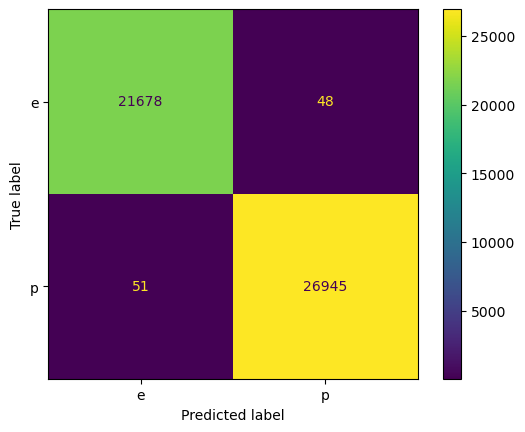

In [27]:
best_model = cv_results['svc'].best_estimator_
best_model.fit(X_train,y_train)

# confusion matrix of test results
ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_train,
    y_train
)

In [28]:
# Finally, report the test score and confusion matrix 
y_test_predict = best_model.predict(X_test)

test_f2_score = fbeta_score(y_test,y_test_predict,beta=2,pos_label='p')
test_accuracy = accuracy_score(y_test,y_test_predict)
print(f'Test F2-Score: {test_f2_score}\nTest Accuracy: {test_accuracy}')

Test F2-Score: 0.9968782518210197
Test Accuracy: 0.9963057220261062


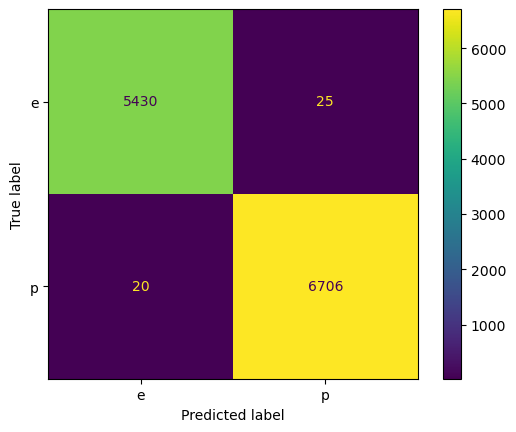

In [29]:
# Plotting confusion matrix for test set
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_predict
)

The prediction model performed quite well on test data, with a final overall accuracy of 0.99 and $F_{\beta}$ score of 0.99. The model only makes 40 mistakes out of 12214 test samples. 17 mistakes were predicting a poisonous mushroom as edible (false negative), while 23 mistakes were predicting a edible mushroom as poisonous (false positive). The model’s performance is promising for implementation, as false negatives represent potential safety risks and these errors could lead to consuming poisonous mushrooms, it is minimized to protect users. On the other hand, false positives are less harmful, they may lead to discarding safe mushrooms unnecessarily but do not endanger safety.

While the overall performance of the SVC model are impressive, efforts could focus on further reducing false negatives to enhance the safety of predictions. It might be important to take a closer look at the 40 misclassified observations to identify specific features contributing to these misclassifications. Implementing feature engineering on those features such as encoding rare categories differently can enhance the model’s power and reduce the misclassification cases. Additionally, trying other classifiers like Decision Tree and Random Forest which are less sensitive to scaling or irrelevant features might improve the prediction.


## References
Wagner, D., Heider, D., & Hattab, G. (2021). Secondary Mushroom [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5FP5Q.

Scikit-learn developers. (n.d.). QuantileTransformer. Scikit-learn. Retrieved November 21, 2024, from https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.QuantileTransformer.html

Hunter, J. D. (2007). Matplotlib: A 2D Graphics Environment. Computing in Science & Engineering, 9(3), 90–95.

McKinney, W. (2010). Data Structures for Statistical Computing in Python. Proceedings of the 9th Python in Science Conference, 51–56.

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., … Duchesnay, E. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825–2830.

Harris, C. R., Millman, K. J., van der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., … Oliphant, T. E. (2020). Array programming with NumPy. Nature, 585(7825), 357–362.

Virtanen, P., Gommers, R., Oliphant, T. E., Haberland, M., Reddy, T., Cournapeau, D., … van der Walt, S. J. (2020). SciPy 1.0: Fundamental Algorithms for Scientific Computing in Python. Nature Methods, 17, 261–272.
